<a href="https://colab.research.google.com/github/Alex45121/AI_Style_sheet/blob/main/Style_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q numpy pandas matplotlib torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 951.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.init as init

In [68]:
csv_path = "/content/drive/MyDrive/AI_project/data/style_rating_template.csv"
images_path = "/content/drive/MyDrive/AI_project/data/Images"
test_image_path = "/content/drive/MyDrive/AI_project/data/Test/Image_city.jpg"
csv_path_2 = "/content/drive/MyDrive/AI_project/data/style_rating_template_Large_cleaned_2.csv"

In [32]:
class StyleDataset(Dataset):

  def __init__(self, csv_file, img_dir, transform = None):
    self.data = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])

    image = Image.open(img_name).convert("RGB")

    if self.transform:
      image = self.transform(image)

    ratings = self.data.iloc[idx, 1:5].values.astype(np.float32)
    ratings = torch.tensor(ratings)

    # Load tags
    tags = self.data.iloc[idx, 5]  # this will be a string for now



    return image, ratings, tags


In [33]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.ToTensor()           # Convert PIL Image to tensor
])

In [34]:
dataset = StyleDataset(csv_file=csv_path_2, img_dir = images_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

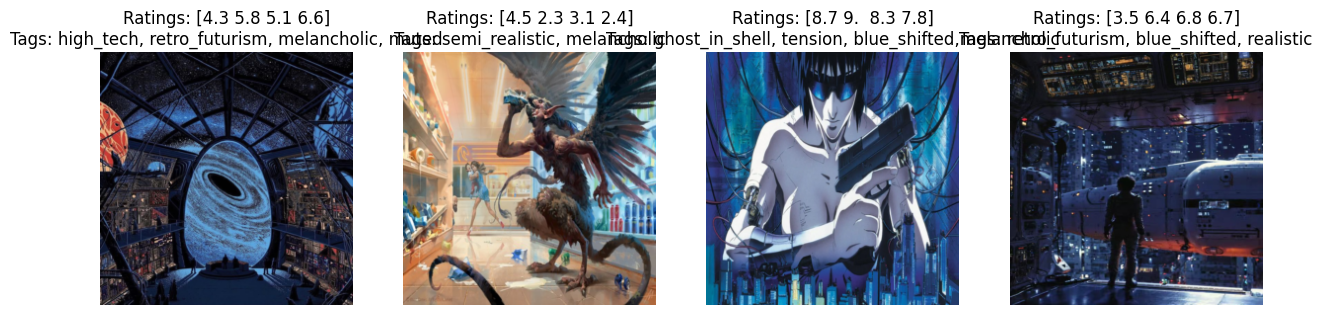

In [35]:
def show_batch(images, ratings, tags):
    fig, axes = plt.subplots(1, len(images), figsize=(15,5))
    for idx, img in enumerate(images):
        img = img.permute(1, 2, 0)  # rearrange tensor to HWC
        axes[idx].imshow(img)
        axes[idx].set_title(f"Ratings: {ratings[idx].numpy()}\nTags: {tags[idx]}")
        axes[idx].axis('off')
    plt.show()

# Get one batch
images, ratings, tags = next(iter(dataloader))
show_batch(images, ratings, tags)

In [69]:
image_t = Image.open(test_image_path)
image_t = image_t.convert('RGB')

transform_t = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to 64x64 (ensure it's large enough for the model)
    transforms.RandomHorizontalFlip(),  # Data Augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Optional normalization
])

sample_image_t= transform_t(image_t).unsqueeze(0)

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class StyleNet(nn.Module):
    def __init__(self):
        super(StyleNet, self).__init__()

        # Feature extractor (CNN)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers (MLP)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 outputs: style_look, prop_style, color_grading, scene_mood

        init.xavier_uniform_(self.conv1.weight)
        init.xavier_uniform_(self.conv2.weight)
        init.xavier_uniform_(self.fc1.weight)
        init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten

        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training) # Dropout added
        x = self.fc2(x)  # Final output




        return x



In [38]:
model = StyleNet()
model_2 = StyleNet()


In [39]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)


scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3) # reduce lr when validation loss plateaus for 3 epochs
scheduler_2 = ReduceLROnPlateau(optimizer_2, 'min', patience=3) # reduce lr when validation loss plateaus for 3 epochs

In [41]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=66)  # 20% for validation

In [42]:


train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)  # Your existing training data loader

val_dataloader = DataLoader(val_data, batch_size=4, shuffle=False)  # New validation data loader

In [43]:
num_epochs = 11


for epoch in range(num_epochs):
    running_loss = 0.0

    for images, ratings, tags in dataloader:
        # Move to GPU if available
        images = images
        ratings = ratings

        # Zero the parameter gradients
        optimizer_2.zero_grad()

        # Forward pass
        outputs = model_2(images)

        # Compute Loss


        loss = criterion(outputs, ratings)

        # Backward pass + optimize
        loss.backward()
        optimizer_2.step()

        running_loss += loss.item()

    model_2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_ratings, val_tags in val_dataloader:  # Your validation data

          outputs = model_2(val_images)

          val_loss += criterion(outputs, val_ratings).item()
        val_loss /= len(val_dataloader)

    scheduler_2.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/11], Loss: 44.7985, Val Loss: 8.4937
Epoch [2/11], Loss: 6.8077, Val Loss: 5.4021
Epoch [3/11], Loss: 5.4398, Val Loss: 5.1712
Epoch [4/11], Loss: 5.1082, Val Loss: 3.3682
Epoch [5/11], Loss: 3.6969, Val Loss: 3.0029
Epoch [6/11], Loss: 2.9860, Val Loss: 1.8849
Epoch [7/11], Loss: 1.9468, Val Loss: 1.0172
Epoch [8/11], Loss: 1.3765, Val Loss: 1.0020
Epoch [9/11], Loss: 0.9451, Val Loss: 0.7585
Epoch [10/11], Loss: 0.8724, Val Loss: 0.8431
Epoch [11/11], Loss: 0.6171, Val Loss: 0.2458


In [70]:

# Predict with image outsdie of testing
model_2.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model_2(sample_image_t)
    prediction = torch.clamp(prediction,(10 * (prediction - 1) / (10 - 1)))


print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[6.1078, 4.2382, 2.3983, 4.0129]])


In [44]:
# Pick an image
sample_image, _, _ = dataset[70]  # 0 = first image
sample_image = sample_image.unsqueeze(0)

# Predict
model_2.eval()  # set model to evaluation mode
with torch.no_grad():
    prediction = model_2(sample_image)
    prediction = torch.clamp(prediction, 0.0, 10.0)

print("Predicted Ratings:", prediction)

Predicted Ratings: tensor([[6.3549, 5.8997, 5.1705, 2.4206]])


In [71]:
torch.save(model_2.state_dict(), "/content/drive/MyDrive/AI_project/models/model_2_test_2_big.pth")

In [72]:
!ls /content/drive/MyDrive/AI_project/models/

model_2_test_2_big.pth	model_test_1.pth
